<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/lauri/pytorch-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Download data

In [3]:
!wget -q -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -q -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
!wget -q -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv

!wget -q -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -q -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
!wget -q -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv

# import python libraries

- numpy
- pandas
- pytorch
- scikit
- matplotlib

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from scipy.sparse import *
import sklearn.utils
import matplotlib.pyplot as plt

# Set up functions

- **shuffle** shuffles pandas dataframe
- **make_labels** takes in pandas dataframe and transforms it into tensor
- **create_dataset** takes anger and joy files, opens them into pandas dataframe and changing labels not-joy and not-anger into neutral
- **create_dataset_and_testset** takes in pandas dataframes and tranforms them into pytorch tensor
- **score** takes in model and tensors, scoring them
- **torch_shuffle** -- incomplete

In [5]:
def shuffle(data):
  data = sklearn.utils.shuffle(data)
  data.reset_index(inplace=True, drop=True)
  return data

In [6]:
def make_labels(labels):
  y = []
  for i in labels:
    if i == 'joy':
      y.append([1,0,0])
    elif i == 'anger':
      y.append([0,1,0])
    elif i == 'neutral':
      y.append([0,0,1])
  y = torch.tensor(y).float()
  return y

In [7]:
def create_dataset(angerpath, joypath):
  anger = pd.read_csv(angerpath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
  joy= pd.read_csv(joypath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')

  df = pd.concat([joy, anger])
  df['emotion'].replace({'not-joy':'neutral', 'not-anger':'neutral'}, inplace=True)
  df = shuffle(df)

  return df

In [8]:
def create_dataset_and_testset(pandas_dataset, vectorizer):

  feature_matrix = vectorizer.transform(pandas_dataset['text'])
  mat = feature_matrix.astype('float').toarray()
  X = torch.from_numpy(mat)
  y = make_labels(pandas_dataset['emotion'])

  return X, y

In [9]:
def score(model, dataset, labels, dataset_size=2024):
  total = 0
  for i in range(dataset_size):
    pred = model(dataset[i].float())
    n1 = pred.detach().cpu().numpy().argmax()
    n2 = labels[i].detach().cpu().numpy().argmax()
    if n2 == n1:
      total += 1
    
  return total/dataset_size*100

In [123]:
def torch_shuffle(df, vectorizer):
  df = shuffle(df)
  X, y = create_dataset_and_testset(df, vectorizer)
  return X, y

# Initialize data

In [11]:
dataset = create_dataset('/content/anger-train.tsv', '/content/joy-train.tsv')
vectorizer=CountVectorizer(analyzer='word', ngram_range=(1,1))
vectorizer.fit(dataset['text'])
dataset_train, labels_train = create_dataset_and_testset(dataset, vectorizer)

In [12]:
dataframe_dev = create_dataset('/content/anger-dev.tsv', '/content/joy-dev.tsv')
dataset_dev, labels_dev = create_dataset_and_testset(dataframe_dev, vectorizer)

In [13]:
dataframe_test = create_dataset('/content/anger-test.tsv', '/content/joy-test.tsv')
dataset_test, labels_test = create_dataset_and_testset(dataframe_test, vectorizer)

# Setup pytorch device

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
dataset_train = dataset_train.to(device)
labels_train = labels_train.to(device)

dataset_dev = dataset_dev.to(device)
labels_dev = labels_dev.to(device)

dataset_test = dataset_test.to(device)
labels_test = labels_test.to(device)

# Init neural network

In [127]:
class Net(nn.Module):
  def __init__(self, size):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(size, 100)
    self.fc2 = nn.Linear(100, 3)

  def forward(self, X):

    out = self.fc1(X)
    out = torch.relu(out)

    out = self.fc2(out)

    return out

# Setup neural network, loss function and optimizer

In [128]:
vocab_size = dataset_train.shape[1]

model = Net(vocab_size)
loss_function = nn.MSELoss(reduction='mean')
optimizer = optim.Adadelta(model.parameters())

accuracy = []
losses = []

model = model.to(device)
loss_function = loss_function.to(device)

# Train model

In [129]:
for epoch in range(50):
  print('epoch ', epoch, ' loss ', round(running_loss,3))
  running_loss = 0.0

  for i in range(2025):    
    optimizer.zero_grad()

    out = model(dataset_train[i].float())
    loss = loss_function(out, labels_train[i])
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        accuracy.append(score(model, dataset_train[:50], labels_train[:50], 50))
        losses.append(running_loss/100)
        running_loss = 0.0

epoch  0  loss  0.0
epoch  1  loss  3.493
epoch  2  loss  2.594
epoch  3  loss  1.739
epoch  4  loss  1.45
epoch  5  loss  1.062
epoch  6  loss  1.033
epoch  7  loss  0.782
epoch  8  loss  0.863
epoch  9  loss  0.644
epoch  10  loss  0.559
epoch  11  loss  0.501
epoch  12  loss  0.471
epoch  13  loss  0.424
epoch  14  loss  0.408
epoch  15  loss  0.311
epoch  16  loss  0.301
epoch  17  loss  0.183
epoch  18  loss  0.288
epoch  19  loss  0.128
epoch  20  loss  0.204
epoch  21  loss  0.135
epoch  22  loss  0.13
epoch  23  loss  0.109
epoch  24  loss  0.076
epoch  25  loss  0.114
epoch  26  loss  0.083
epoch  27  loss  0.09
epoch  28  loss  0.054
epoch  29  loss  0.085
epoch  30  loss  0.038
epoch  31  loss  0.062
epoch  32  loss  0.038
epoch  33  loss  0.051
epoch  34  loss  0.052
epoch  35  loss  0.039
epoch  36  loss  0.047
epoch  37  loss  0.035
epoch  38  loss  0.041
epoch  39  loss  0.044
epoch  40  loss  0.057
epoch  41  loss  0.035
epoch  42  loss  0.053
epoch  43  loss  0.04
epoc

# SCORES

In [130]:
print('Train ', round(score(model, dataset_train, labels_train, dataset_size=2025), 3))
print('Devel ', round(score(model, dataset_dev, labels_dev, dataframe_dev.shape[0]), 3))
print('Test ', round(score(model, dataset_test, labels_test, dataframe_test.shape[0]), 3))

Train  99.457
Devel  77.333
Test  78.716


# Statistics

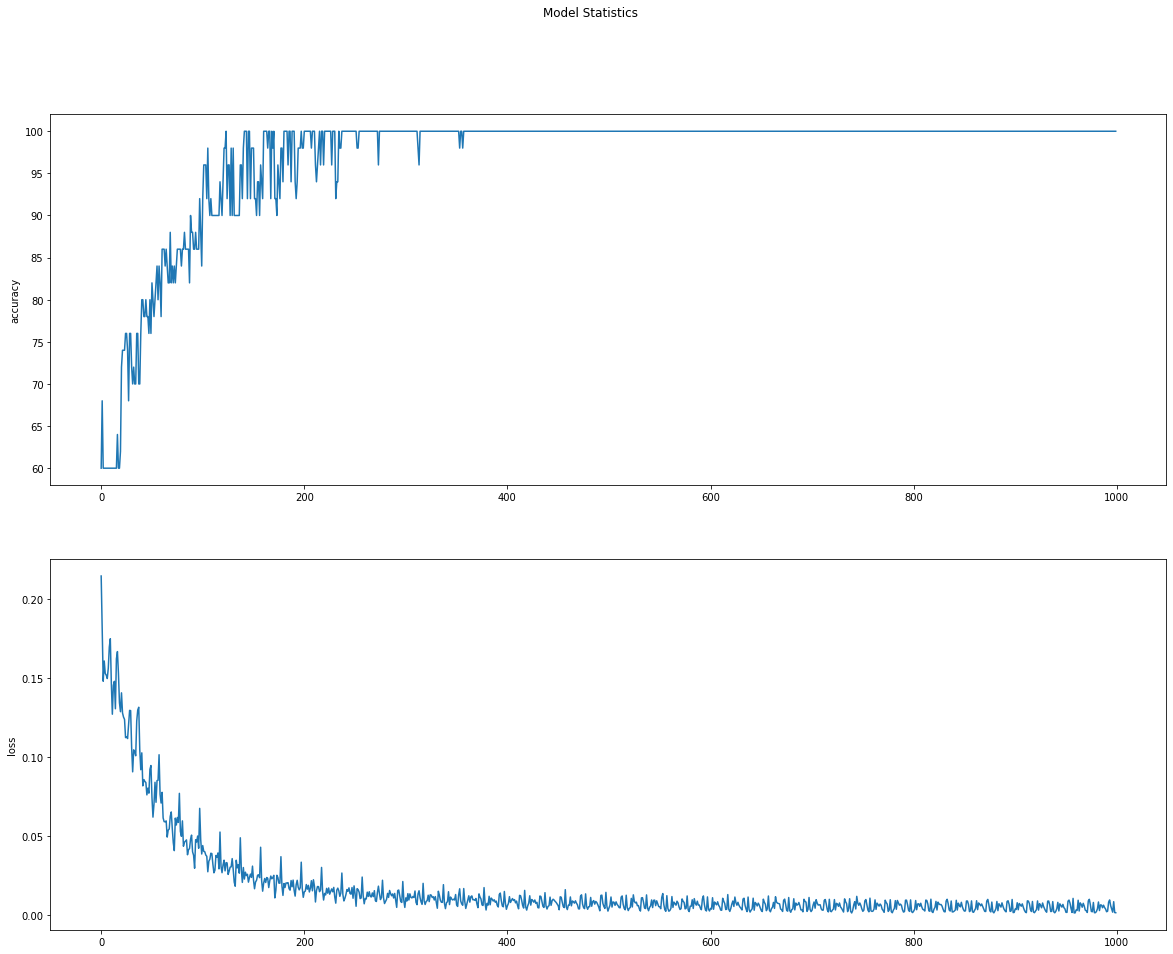

In [131]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()